# `aisim` -- Simulations for light-pulse atom interferometry

## Installation

```
git clone https://github.com/bleykauf/aisim.git
cd aisim
python setup.py install
```

Alternatively, if you plan to make changes to the code, use

```
python setup.py develop
```

## Usage

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

import aisim as ais

Checking the currently installed version:

In [2]:
print(ais.__version__)

v0.1.0+2.g62efa8a.dirty


## Examples

### Effect of wavefront aberrations in atom interferometry

As an example, we reproduce two plots from the paper https://link.springer.com/article/10.1007/s00340-015-6138-5.

The simulation will require the following objects and parameters
* `Wavefront`: contains the wavefront aberrations of the interferometry lasers
* `AtomicEnsemble`: an ensemble of atoms which different trajectors or phase space vectors
* `Detector`: determines which atoms contribute to the signal
* `t`: times of the three interferometer pulses

#### Loading and preparing wavefront data

Wavefront aberration in multiples of $\lambda$ = 780 nm. 

Load Zernike coefficients from file:

In [3]:
coeff_window2 = np.loadtxt('data/wf_window2.txt')
coeff_window5 = np.loadtxt('data/wf_window5.txt')

Creating `Wavefront` objects and removing piston, tip and tilt from the data:

In [4]:
r_beam = 11e-3 # 1/e^2 beam radius in m

wf2 = ais.Wavefront(r_beam, coeff_window2)
wf5 = ais.Wavefront(r_beam, coeff_window5)
for n in [0,1,2]:
    wf2.coeff[n] = 0
    wf5.coeff[n] = 0

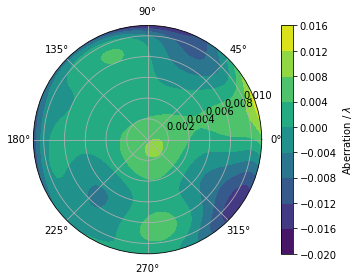

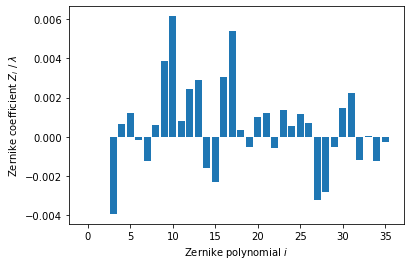

In [5]:
wf2.plot()
fig, ax = wf2.plot_coeff()

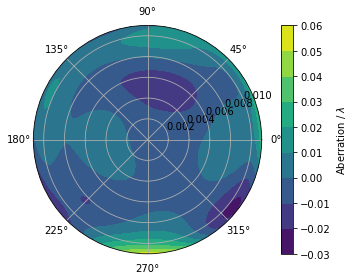

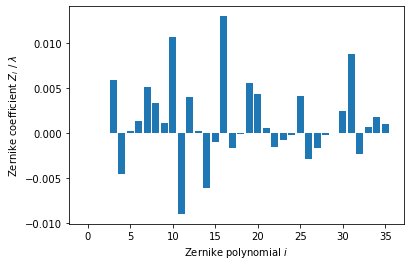

In [6]:
wf5.plot()
fig, ax = wf5.plot_coeff()

#### Creating an atomic ensemble

Due to the large number of parameters determining an atomic ensemble, dictionaries are used:

In [7]:
pos_params = {
    'std_rho' : 3.0e-3, # cloud radius in m
    'std_z' : 0,        # ignore z dimension, its not relevant here
    'n_rho' : 20,       # within each standard deviation of the distribution we use 20 points
    'n_theta' : 36,     # using a resolution of 10°
    'n_z' : 1,          # use one value for the distribution along z
    'm_std_rho' : 3,    # use 3 standard deviations of the distribution, i.e. atoms up to 9 mm away from the center
    'm_std_z' : 0,      # ignore z dimension, its not relevant here 
    'weight' : 'gauss'  # each point on the grid is weighted according to a Guassian distribution
}

vel_params = {
    'std_rho' : ais.vel_from_temp(3e-6), # velocity spread in m/s from a temperature of 3 uK
    'std_z' : 0,                         # ignore z dimension, its not relevant here
    'n_rho' : 20,                        # within each standard deviation of the distribution we use 20 points
    'n_theta' : 36,                      # using a resolution of 10°
    'n_z' : 1,                           # use one value for the distribution along z
    'm_std_rho' : 3,                     # use 3 standard deviations of the distribution
    'm_std_z' : 0,                       # ignore z dimension, its not relevant here 
    'weight' : 'gauss'                   # each point on the grid is weighted according to a Guassian distribution
}

atoms = ais.create_ensemble_from_grids(pos_params, vel_params)

Plotting the grid and the weights:

In [8]:
x = atoms.initial_position[:, 0]
y = atoms.initial_position[:, 1]

Text(0, 0.5, 'y / mm')

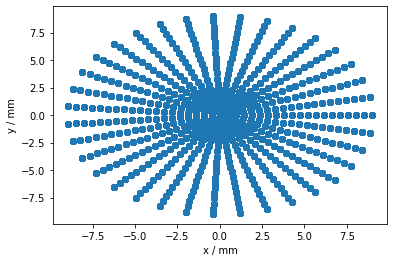

In [9]:
fig, ax = plt.subplots()
ax.scatter(1e3*x, 1e3*y)
ax.set_xlabel('x / mm')
ax.set_ylabel('y / mm')

Text(0, 0.5, 'weights')

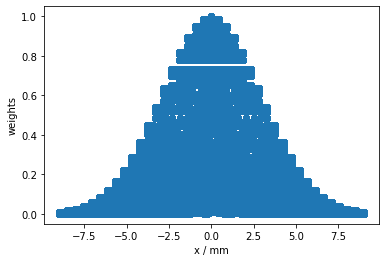

In [10]:
fig, ax = plt.subplots()
ax.scatter(1e3*x, atoms.weights)
ax.set_xlabel('x / mm')
ax.set_ylabel('weights')

#### Setting up the detector

We want to calculate the dependency of the phase shift caused by wavefront aberrations on the detection area. For this reason, we set up a Detector with varying detection radius within a for-loop.

In [11]:
t_det = 778e-3 # time of the detection in s

#### Simulation the bias in gravity from wavefront aberrations

For the simulation we need the objects created above and the timing of the interferometer sequence.

In [12]:
T = 260e-3
t1 = 129.972e-3 # ms 
t2 = t1 + T # ms
t3 = t2 + T # ms
t = [t1, t2, t3]

In [13]:
awf_win2 = []
awf_win5 = []
r_dets = np.linspace(2e-3, 10e-3, 10)
for r_det in r_dets:
    # creating detector with new detection radius
    det = ais.Detector(r_det, t_det)
    
    awf_win2.append(ais.mz_interferometer(t, wf2, atoms, det))
    awf_win5.append(ais.mz_interferometer(t, wf5, atoms, det))

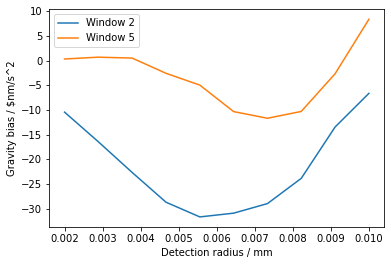

In [14]:
fig, ax = plt.subplots()
ax.plot(1e3*r_dets, ais.convert.rad_to_grav(np.angle(awf_win2)), label='Window 2')
ax.plot(1e3*r_dets, ais.convert.rad_to_grav(np.angle(awf_win5)), label='Window 5')
ax.set_xlabel('Detection radius / mm')
ax.set_ylabel('Gravity bias / $nm/s^2');
ax.legend()